# AutoRegressive Integrated Moving Average (ARIMA)

ARIMA (p, d, q) is a widely used statistical method for time series forecasting. It is particularly effective for datasets that exhibit trends and patterns over time, under the assumption that these patterns are linear and consistent. ARIMA is primarily applied to univariate time series data, such as stock prices, demand forecasting, or weather trends.

The method integrates three key components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). Below is a brief overview of each component and their roles in the forecasting process:

1. ___AutoRegressive (AR) Component (_p_)___
The AR part of the model represents a regression of the variable on its own lagged (previous) values. It captures the relationship between the current value and its past values.
<br><br>

2. ___Integrated (I) Component (_d_)___
The I component represents differencing of the time series to make it stationary, which means the statistical properties of the series (mean, variance, autocorrelation) are constant over time.
<br><br>

3. ___Moving Average (MA) Component (_q_)___
The MA part models the relationship between the current observation and past forecast errors. It smooths out noise by considering the errors in previous periods.

### 01. Import libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import itertools
from math import sqrt

# Graph
import plotly.graph_objs as go
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Data source
import yfinance as yf

# Create features (datetime)
from fastai.tabular.core import add_datepart

In [2]:
# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

### 02. Import data

__yfinance__ is a Python library that simplifies access and manipulation of financial data, allowing users to easily interact with historical and current stock market data. Here are the main reasons to use it:

In [3]:
# Download historical data for a stock
ticker = 'EURUSD=X'
df = yf.download(tickers=ticker, period='10y', interval='1d')

# Move the index to a column
df = df.reset_index()

# Drop the MultiIndex level (keep the first level only)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

# Replace blank space in the name of the columns
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.head()

[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume
0,2015-01-05,1.194643,1.197590,1.188909,1.195500,0
1,2015-01-06,1.193902,1.197000,1.188693,1.193830,0
2,2015-01-07,1.187536,1.190000,1.180401,1.187479,0
3,2015-01-08,1.183600,1.184806,1.175601,1.183894,0
4,2015-01-09,1.179607,1.183830,1.176831,1.179426,0


In [4]:
# Declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Live share price evolution',
    yaxis_title='Stock Price (USD per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=3, label="3h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show
fig.show()

### 03. Feature engineering

Feature engineering involves transforming, creating, and selecting the most relevant features from the original data to enhance the accuracy and efficiency of predictive models.

In this case, extensive feature engineering is less critical since the model focuses exclusively on the 'close' column.

In [5]:
# Create a column for the previous day's close
df['prev_close'] = df.shift(1)['close']

# Calculate the daily change in the closing price
df['close_change'] = df.apply(
    lambda row: 0 if np.isnan(row.prev_close) else (row.close - row.prev_close), 
    axis=1
)

# Remove the temporary prev_close column
df.drop('prev_close', axis=1, inplace=True)

# Calculate the return
df['return'] = (df['close']-df['open'])/df['open']

df.head()

Price,date,close,high,low,open,volume,close_change,return
0,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,0.000000,-0.000717
1,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060
2,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.006366,0.000047
3,2015-01-08,1.183600,1.184806,1.175601,1.183894,0,-0.003936,-0.000249
4,2015-01-09,1.179607,1.183830,1.176831,1.179426,0,-0.003993,0.000153


In [6]:
# Ensure the 'date' column is the index
df = df.set_index('date')

# Make the DataFrame have daily frequency (including weekends)
df = df.asfreq('D')

# Forward fill missing data (weekends will be filled with the previous available data)
df = df.ffill(downcast='infer')

# Sort by date to ensure it's in chronological order
df = df.sort_index()

# Reset the index if you want to move 'date' back to a column
df = df.reset_index()

df.head()

Price,date,close,high,low,open,volume,close_change,return
0,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,0.000000,-0.000717
1,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060
2,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.006366,0.000047
3,2015-01-08,1.183600,1.184806,1.175601,1.183894,0,-0.003936,-0.000249
4,2015-01-09,1.179607,1.183830,1.176831,1.179426,0,-0.003993,0.000153


In [7]:
# Specify the lag features for which rolling statistics will be calculated
lag_features = ["high", "low", "volume"]

# Define rolling window sizes
window1 = 3
window2 = 7
window3 = 30

# Calculate rolling windows for each feature with specified sizes
df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

# Calculate the rolling means for each window and shift by 1 to avoid data leakage
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

# Calculate the rolling standard deviations for each window and shift by 1 to avoid data leakage
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

# Add new features for mean and standard deviation for each lag feature and window size
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

# Fill any remaining NaN values with the column-wise mean to ensure a clean dataset
df.fillna(df.mean(), inplace=True)

df.head()

Price,date,close,high,low,open,volume,close_change,return,high_mean_lag3,high_mean_lag7,...,low_mean_lag30,low_std_lag3,low_std_lag7,low_std_lag30,volume_mean_lag3,volume_mean_lag7,volume_mean_lag30,volume_std_lag3,volume_std_lag7,volume_std_lag30
0,2015-01-05,1.194643,1.197590,1.188909,1.195500,0,0.000000,-0.000717,1.122613,1.122696,...,1.115811,0.002462,0.004237,0.008753,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060,1.197590,1.197590,...,1.188909,0.002462,0.004237,0.008753,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.006366,0.000047,1.197295,1.197295,...,1.188801,0.000153,0.000153,0.000153,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-08,1.183600,1.184806,1.175601,1.183894,0,-0.003936,-0.000249,1.194864,1.194864,...,1.186001,0.004851,0.004851,0.004851,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-09,1.179607,1.183830,1.176831,1.179426,0,-0.003993,0.000153,1.190602,1.192349,...,1.183401,0.006623,0.006537,0.006537,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Save data in other variable, then make it a index
df['date_temp'] = df['date']

# Add date parts
df = add_datepart(df, 'date')
df.drop('Elapsed', axis=1, inplace=True)
df['mon_fri'] = ((df['Dayofweek'] == 0) | (df['Dayofweek'] == 4)).astype(int)

# Replace blank space in the name of the columns
df.columns = df.columns.str.lower().str.replace(' ','_')

# Convert all boolean columns to 1 and 0
boolean_columns = ['is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start'] 
df[boolean_columns] = df[boolean_columns].astype(int)

# # Set 'date' column as the index
df.set_index('date_temp', inplace=True)

df.head()

Price,close,high,low,open,volume,close_change,return,high_mean_lag3,high_mean_lag7,high_mean_lag30,...,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,mon_fri
date_temp,,,,,,,,,,,,,,,,,,,,,
2015-01-05,1.194643,1.197590,1.188909,1.195500,0,0.000000,-0.000717,1.122613,1.122696,1.123127,...,5,0,5,0,0,0,0,0,0,1
2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.000742,0.000060,1.197590,1.197590,1.197590,...,6,1,6,0,0,0,0,0,0,0
2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.006366,0.000047,1.197295,1.197295,1.197295,...,7,2,7,0,0,0,0,0,0,0
2015-01-08,1.183600,1.184806,1.175601,1.183894,0,-0.003936,-0.000249,1.194864,1.194864,1.194864,...,8,3,8,0,0,0,0,0,0,0
2015-01-09,1.179607,1.183830,1.176831,1.179426,0,-0.003993,0.000153,1.190602,1.192349,1.192349,...,9,4,9,0,0,0,0,0,0,1


### 04. Pre-processing

Unlike other machine learning models, in the case of time series, __it is crucial to ensure that partitions are performed respecting the temporal order of the data__, avoiding random mixing of the data.

In [9]:
# Split into training and testing
train_size = int(len(df) * 0.90)
df_train, df_test = df[:train_size], df[train_size:]

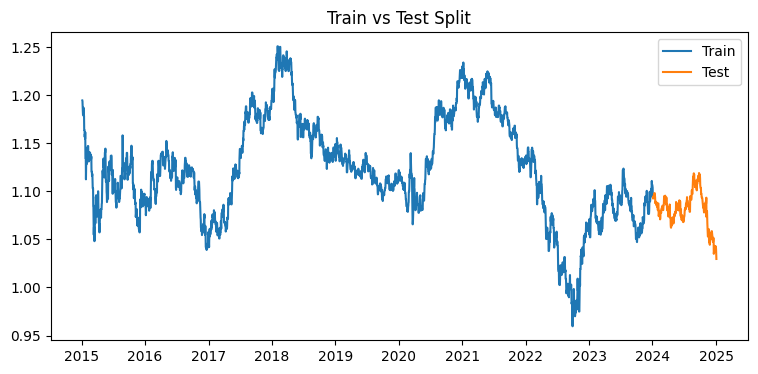

In [10]:
# Visualización del conjunto Train y Test
plt.figure(figsize=(9, 4))
plt.plot(df_train.close, label="Train")
plt.plot(df_test.close, label="Test")
plt.title("Train vs Test Split")
plt.legend()
plt.show()

### 05. Modeling

In this step, the ARIMA(p, d, q) model is configured by determining its three components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). Below is a breakdown of each component and how it is calculated:

- ___p (AutoRegressive):___ Determined by identifying the highest significant lag in the Autocorrelation Function (ACF) plot.
- ___d (Integrated):___ Represents the order of differencing required to make the time series stationary. Typically, this value is 1 or 2 if differencing is necessary.
- ___q (Moving Average):___ Based on the number of significant lags observed in the Partial Autocorrelation Function (PACF) plot.

#### 05.1 Option 1:

In this approach, differencing ___d(I)___ is applied first to make the time series stationary before calculating the values for ___𝑝 (AR)___ and ___𝑞 (MA)___.

This is the traditional method; however, it may result in overly simplistic or flat predictions.

___Estimate d (Integrated)___

In [11]:
# Differencing to Estimate 'd' (Integrated Component)
def stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

In [12]:
# Function to check stationarity
def test_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return p_value

# Function to identify how many differencing steps are needed
def find_differencing_order(series):
    d = 0
    p_value = test_stationarity(series)
    
    # While the series is not stationary (p-value > 0.05), apply differencing
    while p_value > 0.05:
        series = series.diff().dropna()  # Difference the series
        d += 1
        p_value = test_stationarity(series)
        print(f"Differencing step {d}: p-value = {p_value}")
    
    return d

___Estimate p (AutoRegressive) y q (Moving Average)___

In [13]:
def estimate_p_q(series, max_lags=20):
    """
    Automatically estimates the p and q orders for an ARIMA model using ACF and PACF.
    
    Parameters:
    - series: pd.Series, the input time series.
    - max_lags: int, the maximum number of lags to consider in the ACF and PACF plots.
    
    Returns:
    - p: order of the AR (AutoRegressive) component.
    - q: order of the MA (Moving Average) component.
    """
    # Calculating ACF and PACF
    acf_vals, confint_acf = acf(series, nlags=max_lags, alpha=0.05)
    pacf_vals, confint_pacf = pacf(series, nlags=max_lags, alpha=0.05)
    
    # Create a 1x2 subplot layout
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    plot_acf(series, lags=max_lags, ax=ax[0])
    ax[0].set_title("ACF (Estimate q)")
    plot_pacf(series, lags=max_lags, ax=ax[1])
    ax[1].set_title("PACF (Estimate p)")
    plt.tight_layout()
    plt.show()


    # Identify the first lag where ACF and PACF cross the significance limit
    q = next(i for i, val in enumerate(acf_vals[1:], 1) if abs(val) < confint_acf[i][1])  # first lag where ACF crosses upper limit
    p = next(i for i, val in enumerate(pacf_vals[1:], 1) if abs(val) < confint_pacf[i][1])  # first lag where PACF crosses upper limit
    
    print(f"Estimated p (AR): {p}")
    print(f"Estimated q (MA): {q}")
    
    return p, q

___Find the order (p, d, q) and predict___

In [14]:
# Check stationarity of the original series
print("Original Series Stationarity Test:")
stationarity(df_train.close)

Original Series Stationarity Test:
ADF Statistic: -2.5009405936536586
p-value: 0.11524563587341313
Critical Values:
    1%: -3.4323470795742725
    5%: -2.8624223911394444
    10%: -2.5672397153452704
The series is not stationary.


In [15]:
# Check number of estimate 'd'
d_order = find_differencing_order(df_train.close)

print(f"{d_order} differencing step(s) are needed to make the series stationary.")

Differencing step 1: p-value = 0.0
1 differencing step(s) are needed to make the series stationary.


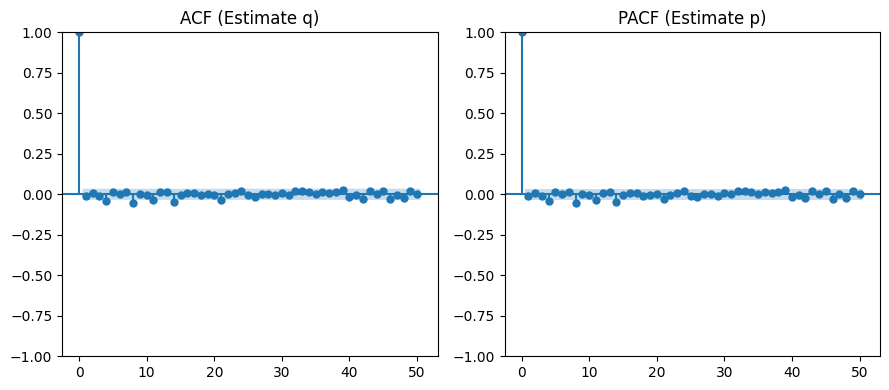

Estimated p (AR): 1
Estimated q (MA): 1


In [16]:
# Apply differencing to make the series stationary
df_train_diff = df_train.close.diff(d_order).dropna()

# Estimate p and q
p_order, q_order = estimate_p_q(df_train_diff, max_lags=50)

In [17]:
# # Manual Estimation
# d_order = 1 # The number of differencing steps needed to make the series stationary.
# p_order = 1 # Determined by the PACF; corresponds to the lag with the highest significant value, followed by the second-highest.
# q_order = 8 # Determined by the ACF; represents the first lag outside the confidence interval (blue shadow).

___Build model, test and predict___

In [18]:
# Fit ARIMA model
arima_model = ARIMA(df_train.close, order=(p_order, d_order, q_order))
fitted_arima_model = arima_model.fit()

# Print model summary
print(fitted_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3286
Model:                 ARIMA(1, 1, 1)   Log Likelihood               12895.626
Date:                Fri, 03 Jan 2025   AIC                         -25785.252
Time:                        08:27:07   BIC                         -25766.961
Sample:                    01-05-2015   HQIC                        -25778.703
                         - 01-03-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0      0.007         -0      1.000      -0.014       0.014
ma.L1               0      0.007          0      1.000      -0.014       0.014
sigma2      2.279e-05   3.14e-07     72.696      0.0

In [19]:
# Make predictions on the test data
# df_test_adj = fitted_arima_model.forecast(steps=len(df_test.close))
df_test_adj = fitted_arima_model.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)

# Calculate performance metrics
def evaluate_model_performance(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
    
    return mse, mae, r2

# Evaluate model performance on test data
mse, mae, r2 = evaluate_model_performance(df_test.close, df_test_adj)

Mean Squared Error: 0.000482089002416975
Mean Absolute Error: 0.017109181060165655
R-squared: -0.46846478130911473


In [20]:
# Adjustment to training
df_train_adj = fitted_arima_model.predict(start=df_train.index[1], end=df_train.index[-1], dynamic=False)

# Adjustment to test
df_test_adj = fitted_arima_model.predict(start=df_test.index[1], end=df_test.index[-1], dynamic=False)

# Make predictions to 10 day more
predictions = fitted_arima_model.predict(start=df.index[-1], end=df.index[-1] + pd.Timedelta(10, freq='D'), steps=10, dynamic=False)

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for training data
trace2 = go.Scatter(
    x=df_train_adj.index,
    y=df_train_adj.values,
    mode='lines',
    line=dict(dash='dash'),
    name='Training Adjustment'
)

# Create a trace for test data
trace3 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace4 = go.Scatter(
    x=df_test_adj.index,
    y=df_test_adj.values,
    mode='lines',
    line=dict(dash='dash'),
    name='Test Adjustment'
)

# Create a trace for predicted values
trace5 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3, trace4, trace5]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()

#### 05.2 Option 2:

In this approach, auto_arima automatically determines the optimal values for the differencing (d), autoregressive (p), and moving average (q) terms based on model selection criteria like AIC, BIC, etc. This removes the need for manual specification of these values.

In [21]:
model_auto_arima = auto_arima(df_train.close, 
                             start_p=0,                     # Starting value for the AR parameter p
                             start_q=0,                     # Starting value for the MA parameter q
                             test='adf',                    # Use Augmented Dickey-Fuller (ADF) test to find optimal 'd'
                             max_p=50,                      # Maximum value for the AR parameter p to search
                             max_q=50,                      # Maximum value for the MA parameter q to search
                             m=1,                           # Frequency of the series (1 means no seasonality)
                             d=None,                        # Let the model automatically determine the differencing order d
                             seasonal=False,                # No seasonality in the data
                             start_P=0,                     # Starting value for the seasonal AR parameter P (not used since seasonal=False)
                             D=0,                           # Seasonal differencing order D (not used since seasonal=False)
                             trace=True,                    # Show the progress of model fitting with intermediate outputs
                             error_action='ignore',         # Ignore errors encountered during model fitting
                             suppress_warnings=True,        # Suppress warnings to reduce clutter in output
                             stepwise=True)                 # Use stepwise search for parameter tuning (faster and more efficient)

# Fit the model
fitted_model_auto_arima = model_auto_arima.fit(df_train.close)

print(fitted_model_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25787.387, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25785.696, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25785.690, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25789.252, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25783.386, Time=6.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 9.910 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3286
Model:               SARIMAX(0, 1, 0)   Log Likelihood               12895.626
Date:                Fri, 03 Jan 2025   AIC                         -25789.252
Time:                        08:27:17   BIC                         -25783.155
Sample:                    01-05-2015   HQIC                        -25787.069
                         - 01-03-2024                             

In [22]:
# Apply auto_arima to automatically select the best p, d, q values
model_auto_arima = auto_arima(df_train.close, seasonal=False, trace=True, 
                              stepwise=True, suppress_warnings=True)

# Fit the model
fitted_model_auto_arima = model_auto_arima.fit(df_train.close)

print(fitted_model_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-25780.256, Time=7.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-25787.387, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-25785.696, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25785.690, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-25789.252, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25783.386, Time=6.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 18.250 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3286
Model:               SARIMAX(0, 1, 0)   Log Likelihood               12895.626
Date:                Fri, 03 Jan 2025   AIC                         -25789.252
Time:                        08:27:36   BIC                         -25783.155
Sample:                    01-05-2015   HQIC                        -25787.0

In [23]:
# Make predictions on the test data
df_test_adj = fitted_model_auto_arima.predict(n_periods=len(df_test.close))
# df_test_adj = fitted_model_auto_arima.predict(start=df_test.index[1], end=df_test.index[-1], dynamic=False)

# Calculate performance metrics
def evaluate_model_performance(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
    
    return mse, mae, r2

# Evaluate model performance on test data
mse, mae, r2 = evaluate_model_performance(df_test.close, df_test_adj)

Mean Squared Error: 0.000482089002416975
Mean Absolute Error: 0.017109181060165655
R-squared: -0.46846478130911473


In [24]:
# Adjustment to training
df_train_adj = fitted_model_auto_arima.predict(n_periods=len(df_train.close))

# Adjustment to test
df_test_adj = fitted_model_auto_arima.predict(n_periods=len(df_test.close))

# Make predictions to 10 day more
predictions = fitted_model_auto_arima.predict(n_periods=10)
predictions.index = pd.date_range(start=df_test.index[-1] + pd.Timedelta(1, unit='D'), periods=10, freq='D')

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for training data
trace2 = go.Scatter(
    x=df_train.index,
    y=df_train_adj.values,
    mode='lines',
    line=dict(dash='dash'),
    name='Training Adjustment'
)

# Create a trace for test data
trace3 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace4 = go.Scatter(
    x=df_test_adj.index,
    y=df_test_adj.values,
    mode='lines',
    line=dict(dash='dash'),
    name='Test Adjustment'
)

# Create a trace for predicted values
trace5 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3, trace4, trace5]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()

#### 05.3 Option 3:

In this approach, the ARIMA model is manually tuned by using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to determine the appropriate lag values for the Moving Average (q) and AutoRegressive (p) components. Here's how it works:

Differencing is still considered, but ACF and PACF are used to identify the optimal values of ___𝑝___ and ___q___ directly from the data before applying the differencing step. The order of differencing is determined by the ADF test, which checks for stationarity.

This could lead to different prediction behaviors compared to using a simpler forecast method, as it incorporates a more complex understanding of the time series structure (including trends and seasonality).

In [25]:
def get_arima_price(df, fact): #, forecast_steps):
    
    #MA Lags
    acf_coef = acf(df[fact], alpha=.05)
    sig_acf = []
    for i in range(1, len(acf_coef[0])):
        if acf_coef[0][i] > (acf_coef[1][i][1] - acf_coef[0][i]):
            sig_acf.append(i)
        elif acf_coef[0][i] < (acf_coef[1][i][0] - acf_coef[0][i]):
            sig_acf.append(i)

    #AR Lags
    pacf_coef = pacf(df[fact], alpha=.05)
    sig_pacf = []
    for i in range(1, len(pacf_coef[0])):
        if pacf_coef[0][i] > (pacf_coef[1][i][1] - pacf_coef[0][i]):
            sig_pacf.append(i)
        elif pacf_coef[0][i] < (pacf_coef[1][i][0] - pacf_coef[0][i]):
            sig_pacf.append(i)

    #Order of integration
    adf = adfuller(x=df[fact], 
                  autolag='BIC')
    order = 0
    if adf[0] < adf[4]['5%']:
        order = 0
    else:
        order = 1

    #Trend indication
    if order == 1:
        trend = 't'
    else:
        trend = 'c'

    #ARIMA(p,d,q) Model
    model = ARIMA(endog = df[fact],
                  order = (sig_pacf, order, sig_acf),
                  trend = trend).fit()
    
    #forecast = model.get_forecast(forecast_steps, alpha=0.05)

    #predict = model.predict()
    
    #return forecast.summary_frame(), model.summary(), predict

    return model

In [26]:
# Apply function
fitted_arima_model_funct = get_arima_price(df, 'close') #, 20)

print(fitted_arima_model_funct.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   close   No. Observations:                 3652
Model:             ARIMA([1, 5, 9, 12, 15, 22], 1, 35)   Log Likelihood               14445.378
Date:                                 Fri, 03 Jan 2025   AIC                         -28804.756
Time:                                         08:32:32   BIC                         -28538.038
Sample:                                     01-05-2015   HQIC                        -28709.772
                                          - 01-03-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.934e-05   7.47e-05     -0.661      0.509      -0.000     9.7

In [27]:
# Adjustment to training
df_train_adj = fitted_arima_model_funct.predict(start=df_train.index[1], end=df_train.index[-1], dynamic=False)

# Adjustment to test
df_test_adj = fitted_arima_model_funct.predict(start=df_test.index[1], end=df_test.index[-1], dynamic=False)

# Make predictions to 10 day more
#predictions = fitted_arima_model_funct.predict(start=df.index[-1], end=df.index[-1] + pd.Timedelta(100, freq='D'), steps=100, dynamic=False)

# Make predictions to 10 day more
predictions = fitted_arima_model_funct.get_forecast(10, alpha=0.05)
predictions = predictions.predicted_mean

# Create a trace for training data
trace1 = go.Scatter(
    x=df_train.index,
    y=df_train.close,
    mode='lines',
    name='Training Data'
)

# Create a trace for training data
trace2 = go.Scatter(
    x=df_train_adj.index,
    y=df_train_adj.values,
    mode='lines',
    line=dict(dash='dash'),
    name='Training Adjustment'
)

# Create a trace for test data
trace3 = go.Scatter(
    x=df_test.index,
    y=df_test.close,
    mode='lines',
    name='Test Data'
)

# Create a trace for predicted values
trace4 = go.Scatter(
    x=df_test_adj.index,
    y=df_test_adj.values,
    mode='lines',
    line=dict(dash='dash'),
    name='Test Adjustment'
)

# Create a trace for predicted values
trace5 = go.Scatter(
    x=predictions.index,
    y=predictions.values,
    mode='lines',
    name='Predictions'
)

# Combine all traces in a list
data_x = [trace1, trace2, trace3, trace4, trace5]

# Create a layout
layout = go.Layout(
    title='Actual vs. Predicted Values',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Close Price')
)

# Create a figure
fig = go.Figure(data=data_x, layout=layout)


# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15d", step="day", stepmode="backward"),
            dict(count=45, label="45d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Show the figure
fig.show()

In [28]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(x = df.index, y = df['close'], mode = 'lines', name = 'Observed'))
# fig.add_trace(go.Scatter(x = predict.index[1:], y = predict[1:], mode = 'lines', name = 'ARIMA Model Prediction'))
# fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean'], mode = 'lines', name = 'ARIMA Model Forecast'))
# fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_lower'], mode = 'lines', name = 'Forecast Error', line=dict(color='darkblue')))
# fig.add_trace(go.Scatter(x = forecast.index, y = forecast['mean_ci_upper'], mode = 'lines', line=dict(color='darkblue'), showlegend = False))
# fig.add_trace(go.Scatter(x = [predict.index[-1], forecast.index[0]], y = [predict.iloc[-1], forecast['mean'].iloc[0]], mode = 'lines', name = 'ARIMA Model 1-Day Forecast'))
# fig.add_trace(go.Scatter(x = forecast.index[:4], y = forecast['mean'].iloc[:4], mode = 'lines', name = 'ARIMA Model 4-Day Forecast (Higher Accuracy)'))

# fig.update_layout(
#     autosize=False,
#     width=800,
#     height=500,
#     xaxis_title = 'Days',
#     yaxis_title = 'Price $',
#     title = f'{ticker} Stock Price'
# )

# fig.show()

### 06. Model evaluation and interpretation

- __Option 1 vs Option 2__

Between option 1 and option 2, it can be concluded that there is little difference between manually finding the model and using a tool like auto_arima. Both approaches allow for the identification of optimal parameters for AR and MA terms, and the resulting models often perform similarly. However, auto_arima automates the process, potentially saving time and reducing the likelihood of human error in model selection. Ultimately, the choice between these two methods depends on the user's preference for control and understanding of the model-building process versus the convenience and efficiency of automation.
<br><br>

- __Option 3 vs Option 1, 2__

Even more importantly, when comparing these two models (1 and 2) with option 3, where p and q are selected before differencing, predictions can vary (with trends), compared to the modified function (where differencing is applied first and then p and q are selected).

In Option 3, the lags of AR (p) and MA (q) parameters are calculated on the original series, capturing trends and patterns. In Options 1 and 2, differencing transforms the data into stationary form, removing the trend. By calculating lags on the differenced series, the model only captures stationary relationships, reducing its ability to detect long-term trends in the original data. This may result in flatter predictions, as the model does not directly learn the long-term relationships of the original series.

__In summary, if the series is not stationary, it should be differenced, but it is crucial to select p and q based on the original series to maintain the model's ability to capture trends and long-term relationships.__

### End